<a href="https://colab.research.google.com/github/Shuvam1024/compsr/blob/main/ShuvamSR20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional neural network for image super-resolution on compressed images

**Author:** [Shuvam Mukherjee](shuvam1024@gmail.com)<br>
**Date created:** 08/01/2021<br>
**Last modified:** 12/23/2021<br>
**Description:** Train a deep convolutional network for joint super-resolution and compression artifact removal. 

## Introduction

This example demonstrates how to implement a deep convolutional network
for joint super-resolution and image compression noise mitigation.

## Setup and Helper functions

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import io
from io import BytesIO
import requests

from tensorflow.keras import layers
from tensorflow.keras.layers import Layer
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow import pad


def load_url(url):
    """
    Load npz file from a url
    """
    r = requests.get(url, stream = True)
    x = np.load(BytesIO(r.raw.read()))
    data = x['data']
    noisy_data = x['noisy_data']
    patchsize = x['patchsize'].item(0)
    return data, noisy_data, patchsize

def preprocess(array, patchsize):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), patchsize, patchsize, 1))
    return array

def get_mse(x, y):
    """
    Gets mse of two tensors of size [batchize, height, width]
    """
    mse = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
    return mse(x, y).numpy()


def display2(array1, array2, patchsize):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 12
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(patchsize, patchsize))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(patchsize, patchsize))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


def display3(array1, array2, array3, patchsize):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 12
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]
    images3 = array3[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2, image3) in enumerate(zip(images1, images2, images3)):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(image1.reshape(patchsize, patchsize))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image2.reshape(patchsize, patchsize))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(image3.reshape(patchsize, patchsize))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

## Setup URLs for Training, Validation and Test Sets

In [ ]:
# Choose quality as one of {20, 30, 40, 50}
quality = '20'

# Choose one of {2by1, 8by5, 4by3}
ratio = '2by1'

# Training and Validation set urls (use the ratio string above)
train_url = 'https://storage.googleapis.com/srcompdata/Ratio_' + ratio + 'DIV2K_train_' + ratio + '_' + quality + '_48x48.npz'
train_url = 'https://storage.googleapis.com/srcompdata/Ratio_' + ratio + 'DIV2K_valid_' + ratio + '_' + quality + '_48x48.npz'

# Where to store the trained models
model_out = 'gdrive/My Drive/Colab Notebooks/model_' + ratio + '_50.keras'

# Test set url
test_url = 'https://storage.googleapis.com/srcompdata/Ratio_' + ratio + 'DIV2K_test_' + ratio + '_' + quality + '_64x64.npz'

## Prepare the data

In [ ]:
# Load Training and Validation Data
train_data, noisy_train_data, patchsize = load_url(train_url)
valid_data, noisy_valid_data, vpatchsize = load_url(valid_url)

assert patchsize == vpatchsize

# Normalize and reshape the data
train_data = preprocess(train_data, patchsize)
noisy_train_data = preprocess(noisy_train_data, patchsize)
valid_data = preprocess(valid_data, patchsize)
noisy_valid_data = preprocess(noisy_valid_data, patchsize)

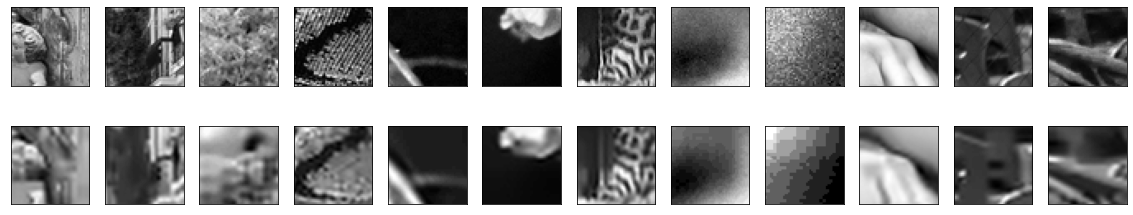

In [ ]:
# Display the train data and a version of it with added noise
display2(train_data, noisy_train_data, patchsize)

In [ ]:
loss_noisy_train = get_mse(train_data, noisy_train_data)
print('Training Noisy MSE: ' + str(loss_noisy_train))
loss_noisy_valid = get_mse(valid_data, noisy_valid_data)
print('Validation Noisy MSE: ' + str(loss_noisy_valid))

Training Noisy MSE: 0.0014760831
Validation Noisy MSE: 0.001611827


## Build the CNN

We are going to use the Functional API to build our convolutional neural network.

In [ ]:
def generate_cnn():

  input = layers.Input(shape=(None, None, 1))

  x = layers.Conv2D(32, (5, 5), activation="tanh", strides=(1, 1), padding="same")(input)
  # x = layers.Conv2D(32, (5, 5), activation="tanh", strides=(2, 2), padding="same")(input)
  # or
  # x = layers.MaxPooling2D((2, 2), padding="same")(x)
  x = layers.Conv2D(28, (3, 3), activation="relu", padding="same")(x)
  x = layers.Conv2D(24, (3, 3), activation="relu", padding="same")(x)
  x = layers.Conv2D(20, (3, 3), activation="relu", padding="same")(x)
  x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(x)

  # Decoder
  #x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
  x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(x)
  x = layers.Conv2D(1, (3, 3), activation="tanh", padding="same")(x)

  # CNN
  cnn = Model(input, x)
  cnn.compile(optimizer="adam", loss="mean_squared_error", metrics=['mse'])
  cnn.summary()

  return cnn

autoencoder = generate_cnn()

Now that we have our network, let's train it using the noisy
data as our input and the clean data as our target. We want our auto encoder network to learn how to super-resolve images in the presencce of compression noise.

In [ ]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=25,
    batch_size=256,
    shuffle=True,
    validation_data=(noisy_valid_data, valid_data),
)

# Mount your Google drive to write the model generated

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

autoencoder.save(model_out)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_12 (Conv2D)          (None, None, None, 32)    832       
                                                                 
 conv2d_13 (Conv2D)          (None, None, None, 28)    8092      
                                                                 
 conv2d_14 (Conv2D)          (None, None, None, 24)    6072      
                                                                 
 conv2d_15 (Conv2D)          (None, None, None, 20)    4340      
                                                                 
 conv2d_16 (Conv2D)          (None, None, None, 16)    2896      
                                                                 
 conv2d_17 (Conv2D)          (None, None, None, 16)    2320

Let's now predict on the noisy validation data and display the results of our autoencoder.

Notice how the autoencoder reduces the MSE between the source and the noisy images.

Mounted at /content/gdrive


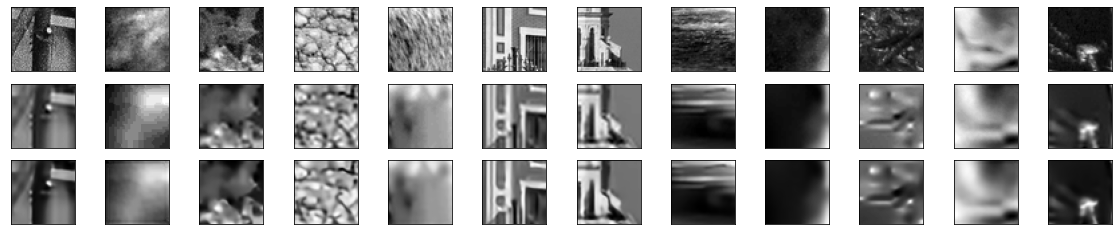

Validation Restored MSE: 0.0014688862
Validation MSE Reduction %: 8.868253231048584


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

autoencoder = tf.keras.models.load_model(model_out)

restored_valid_data = autoencoder.predict(noisy_valid_data)
display3(valid_data, noisy_valid_data, restored_valid_data, patchsize)

loss_restored_valid = get_mse(valid_data, restored_valid_data)
print('Validation Restored MSE: ' + str(loss_restored_valid))
valid_loss_pct = (loss_noisy_valid - loss_restored_valid) / loss_noisy_valid * 100
print('Validation MSE Reduction %: ' + str(valid_loss_pct))

## Test your network on test data.

In [ ]:
# Load the test data

test_data, noisy_test_data, testpatchsize = load_url(test_url)

Test Noisy MSE: 0.0014692439
Test Restored MSE: 0.0013108206
Test MSE Reduction %: 10.782643407583237


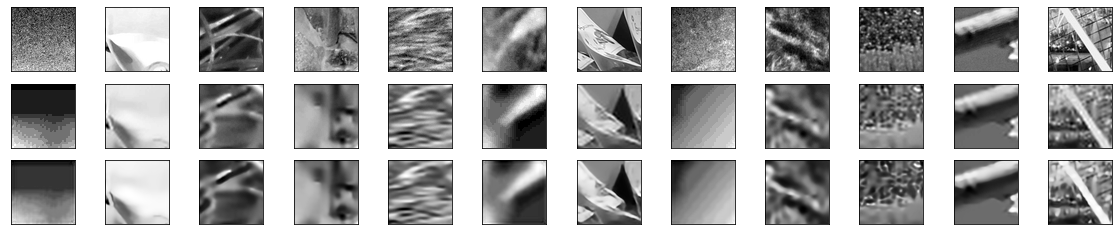

In [ ]:
# Load the trained model and test the reduction in MSE achieved
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

autoencoder = tf.keras.models.load_model(model_out)

# Normalize and reshape the data
test_data = preprocess(test_data, testpatchsize)
noisy_test_data = preprocess(noisy_test_data, testpatchsize)
loss_noisy_test = get_mse(test_data, noisy_test_data)
print('Test Noisy MSE: ' + str(loss_noisy_test))

restored_test_data = autoencoder.predict(noisy_test_data)
loss_restored_test = get_mse(test_data, restored_test_data)
print('Test Restored MSE: ' + str(loss_restored_test))

test_loss_pct = (loss_noisy_test - loss_restored_test) / loss_noisy_test * 100
print('Test MSE Reduction %: ' + str(test_loss_pct))

display3(test_data, noisy_test_data, restored_test_data, testpatchsize)